# KNN Classifier

Aluno: Nathan Sampaio Santos | NUSP: 8988661

Importing required libraries

In [119]:
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from ucimlrepo import fetch_ucirepo
import seaborn as sns
import pandas as pd
import numpy as np

Import Adult dataset 

In [120]:
adult    = fetch_ucirepo(id=2) 

dataset  = pd.merge(adult.data.features, adult.data.targets, left_index=True, right_index=True)
var_info = adult.variables
metadata = adult.metadata

Useful variables

In [121]:
active_feature     = 1
inactive_feature   = 0
target             = ">50k"
training_variables = []

numerical_vars     = var_info[var_info.type=="Integer"].name
categorical_vars   = var_info[(var_info.type.isin(["Binary", "Categorical"])) & (var_info.name != "income")].name

Initial data treatments

In [122]:
dataset                   = dataset.fillna(np.nan)
dataset[target]           = dataset["income"].map({'<=50K': inactive_feature, '>50K': active_feature, '<=50K.': inactive_feature, '>50K.': active_feature})
dataset["workclass"]      = dataset["workclass"].fillna("X")
dataset["occupation"]     = dataset["occupation"].fillna("X")
dataset["native-country"] = dataset["native-country"].fillna("X")

Check if there is no missing data in features

In [123]:
dataset.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
>50k              0
dtype: int64

Filtering relevant features

In the next block, the code will calculate the probability of Income > 50k occurencies for each label in the categorical variables. For every label with frequency below .3 (30%), it will group those features into a single one. Otherwise, it will consider it in as a new feature.

In [124]:
group_variables = {}
new_variables   = {}
threshold       = .3

for variable in categorical_vars:
    variable_map = dataset[[variable, target]].groupby([variable]).mean().sort_values(target, ascending=False).reset_index()
    
    group_variables[variable] = []
    new_variables[variable] = []

    for index, category in variable_map.iterrows():
        if (category[target] <= threshold):
            group_variables[variable].append(category[variable])
        else:
            new_variables[variable].append(category[variable])

In the example below, the categories Bachelors, Masters, Doctorate and Porf-School will become new single features, because their probabilities are higher than 30%. The other ones will be grouped into a category Others.

<Axes: xlabel='>50k', ylabel='education'>

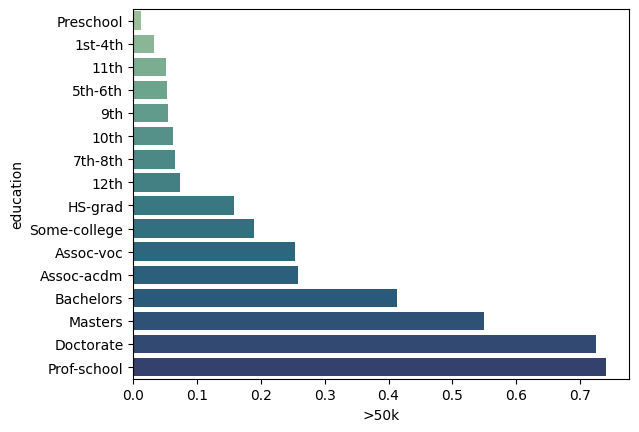

In [125]:
variable = "education"
education_prob = dataset[[variable, target]].groupby([variable]).mean().sort_values(target, ascending=True).reset_index()

sns.barplot(education_prob, x=target, y=variable, hue=variable, palette="crest", width=.8)


In [126]:
#Grouped labels for education
print(group_variables[variable])

['Assoc-acdm', 'Assoc-voc', 'Some-college', 'HS-grad', '12th', '7th-8th', '10th', '9th', '5th-6th', '11th', '1st-4th', 'Preschool']


In [127]:
#New single features for education
print(new_variables[variable])

['Prof-school', 'Doctorate', 'Masters', 'Bachelors']


Creating one-hot-encoding for features and adding them to the list of training variables

In [128]:
for column in group_variables.keys():
    if(len(group_variables[column])>0):
        new_column_name = column + "_others"
        training_variables.append(new_column_name)
        dataset[new_column_name] = list(map(lambda x: active_feature if(x in group_variables[column]) else inactive_feature, dataset[column]))

In [129]:
for column in new_variables.keys():
    for feature in new_variables[column]:
        new_column_name = column + "_" + feature
        training_variables.append(new_column_name)
        dataset[new_column_name] = list(map(lambda x: active_feature if(x == feature) else inactive_feature, dataset[column]))

Adding the numerical features to the list of training variables

In [130]:
training_variables = training_variables + list(numerical_vars)

Treating capital gains and losses, since there is a high correlation between those values being diferent than zero and the person having an income higher than 50k

In [131]:
name = "capital_gains-loss"
dataset[name] = list(map(lambda x, y: active_feature if(x != 0 or y!=0) else inactive_feature, dataset["capital-gain"], dataset["capital-loss"]))
training_variables.append(name)

Removing unuseful training variables

In [132]:
training_variables.remove("capital-gain")
training_variables.remove("capital-loss")
training_variables.remove("fnlwgt")
training_variables.remove("hours-per-week")

#Education is a redundant variable, since it has a high correlation with the number of years of education
training_variables = [x for x in training_variables if ((not x.startswith("education")) or x.startswith("education-num"))]

Final list of training variables

In [133]:
print(training_variables)

['workclass_others', 'marital-status_others', 'occupation_others', 'relationship_others', 'race_others', 'sex_others', 'native-country_others', 'workclass_Self-emp-inc', 'workclass_Federal-gov', 'marital-status_Married-civ-spouse', 'marital-status_Married-AF-spouse', 'occupation_Exec-managerial', 'occupation_Prof-specialty', 'occupation_Armed-Forces', 'occupation_Protective-serv', 'relationship_Wife', 'relationship_Husband', 'sex_Male', 'native-country_France', 'native-country_India', 'native-country_Taiwan', 'native-country_Iran', 'native-country_England', 'native-country_Greece', 'native-country_Yugoslavia', 'native-country_Japan', 'native-country_Canada', 'native-country_Italy', 'native-country_Cambodia', 'native-country_Hungary', 'age', 'education-num', 'capital_gains-loss']


Splitting the dataset into validation and training datasets

In [134]:
X = dataset[training_variables].values
Y = dataset[target].values

validation_size = 0.20
seed = 7
num_folds = 10
scoring = 'accuracy'
X_train, X_validation, Y_train, Y_validation = train_test_split(X,Y,test_size=validation_size,random_state=seed)

kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)

Running the model with different n_neighbors to discover which has the higher accuracy based on the cross-validation test.

The n goes from 1 to 50, with a 5 unit step

In [135]:
results       = None
best_accuracy = 0

for n in range(0, 51, 5):
    n_neighbors = max(n,1)

    cv_results = cross_val_score(KNeighborsClassifier(n_neighbors), X_train, Y_train, cv=kfold, scoring='accuracy')
    current_accuracy = cv_results.mean()

    improvement = current_accuracy - best_accuracy

    results = pd.concat([results, pd.DataFrame([{'n_neighbors': n_neighbors, 'accuracy':current_accuracy, 'improvement' : improvement}])], ignore_index=True)
    print("n: " + str(n_neighbors) + " | accuracy: " + str(current_accuracy) + " | improvement: " + str(improvement))

    best_accuracy = max(current_accuracy, best_accuracy)

n: 1 | accuracy: 0.7910064645274902 | improvement: 0.7910064645274902
n: 5 | accuracy: 0.823228575118695 | improvement: 0.03222211059120472
n: 10 | accuracy: 0.8308040328109613 | improvement: 0.0075754576922663075
n: 15 | accuracy: 0.8325442497640247 | improvement: 0.0017402169530634781
n: 20 | accuracy: 0.8322117035821854 | improvement: -0.0003325461818393105
n: 25 | accuracy: 0.8340800335015309 | improvement: 0.00153578373750618
n: 30 | accuracy: 0.8340799025133745 | improvement: -1.3098815643264317e-07
n: 35 | accuracy: 0.8357435110432185 | improvement: 0.001663477541687608
n: 40 | accuracy: 0.8342590222677245 | improvement: -0.0014844887754940084
n: 45 | accuracy: 0.8347708584885171 | improvement: -0.0009726525547014697
n: 50 | accuracy: 0.8332097612898037 | improvement: -0.0025337497534148046


In [136]:
print("Best n: \n")
print(results.iloc[results.accuracy.idxmax()])

Best n: 

n_neighbors    35.000000
accuracy        0.835744
improvement     0.001663
Name: 7, dtype: float64


Running the final validation test with the best classifier found

In [137]:
best_n_neighbors = results.n_neighbors[results.accuracy.idxmax()]

knn = KNeighborsClassifier(n_neighbors=best_n_neighbors)
knn.fit(X_train, Y_train)
y_pred = knn.predict(X_validation)

Final classifier model validation results

In [138]:
accuracy  = accuracy_score(Y_validation, y_pred)
precision = precision_score(Y_validation, y_pred)
recall    = recall_score(Y_validation, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.8321220186303614
Precision: 0.7277167277167277
Recall: 0.49958088851634536
